Rocket hit ground at step 33601
Results specific to the nominal trajectory:
Specific orbital energy at apogee (epsf) = -62235255.94327908 m²/s²
Angular momentum at apogee (Lf) = 1798158388.578525 m²/s
Suborbital
Distance from earth's center of mass:
Apoapsis = 6400209.574503668 m
Periapsis = 4058.7772366381787 m


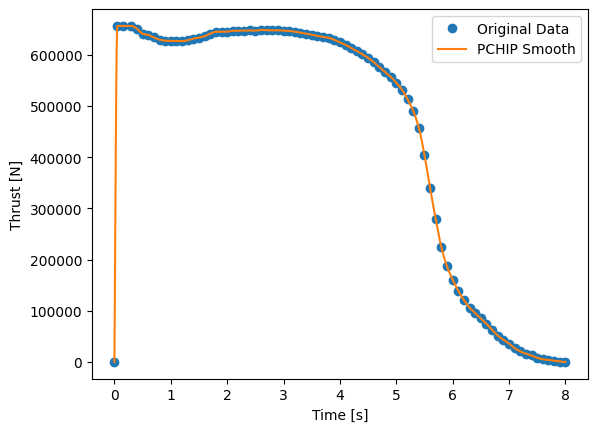

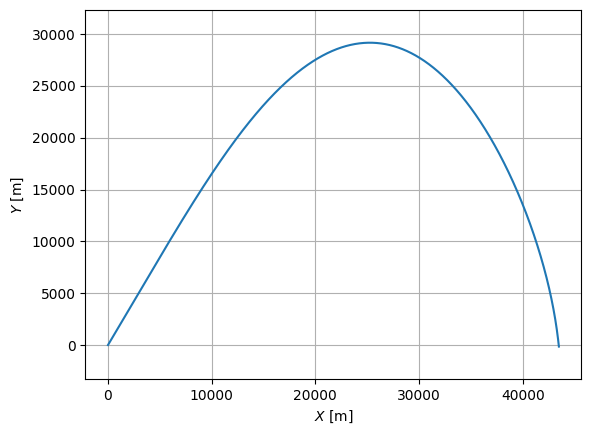

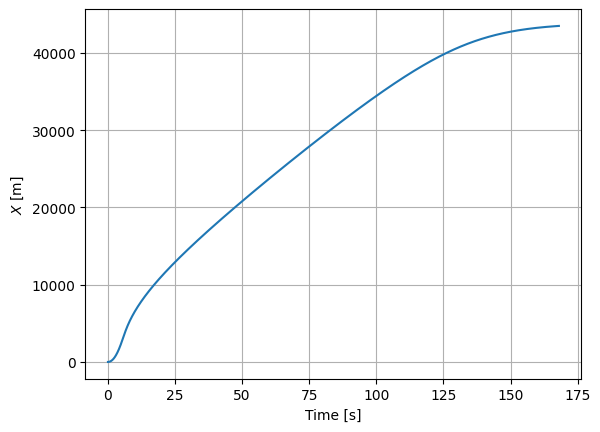

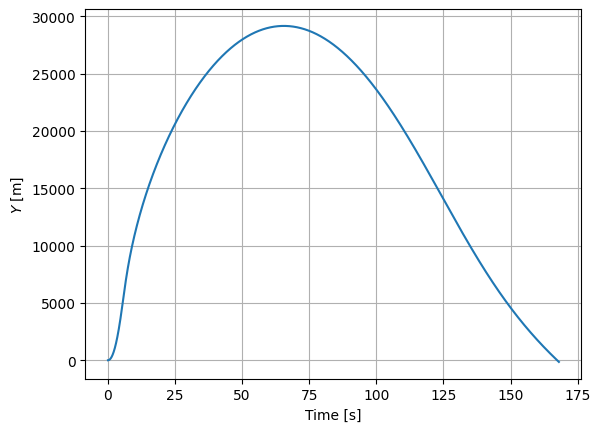

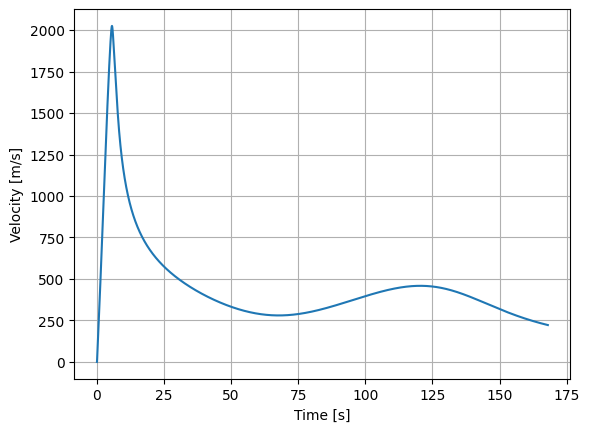

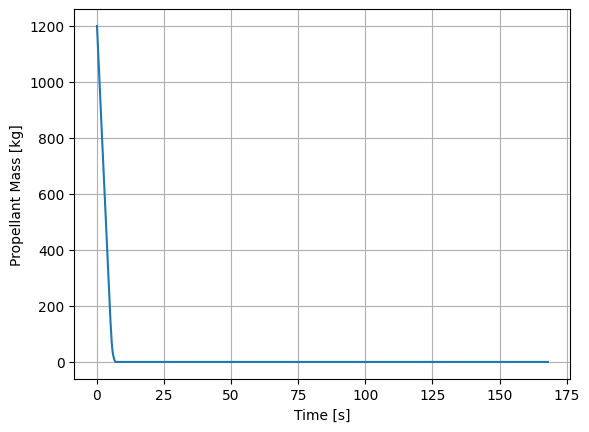

Rocket hit ground at step 33058
Rocket hit ground at step 30989
Rocket hit ground at step 32678
Rocket hit ground at step 33885
Rocket hit ground at step 36719
Rocket hit ground at step 36341
Rocket hit ground at step 31411
Rocket hit ground at step 32224
Rocket hit ground at step 33269
Rocket hit ground at step 29377
Rocket hit ground at step 32409
Rocket hit ground at step 30421
Rocket hit ground at step 36356
Rocket hit ground at step 31349
Rocket hit ground at step 34073
Rocket hit ground at step 38532
Rocket hit ground at step 34163
Rocket hit ground at step 34991
Rocket hit ground at step 31967
Rocket hit ground at step 32881
Rocket hit ground at step 28785
Rocket hit ground at step 35325
Rocket hit ground at step 35925
Rocket hit ground at step 33564
Rocket hit ground at step 35665
Rocket hit ground at step 32262
Rocket hit ground at step 31713
Rocket hit ground at step 39929
Rocket hit ground at step 37088
Rocket hit ground at step 34097
Rocket hit ground at step 33671
Rocket h

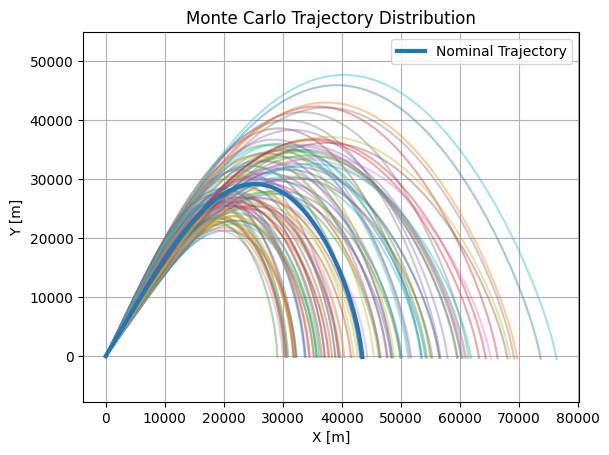

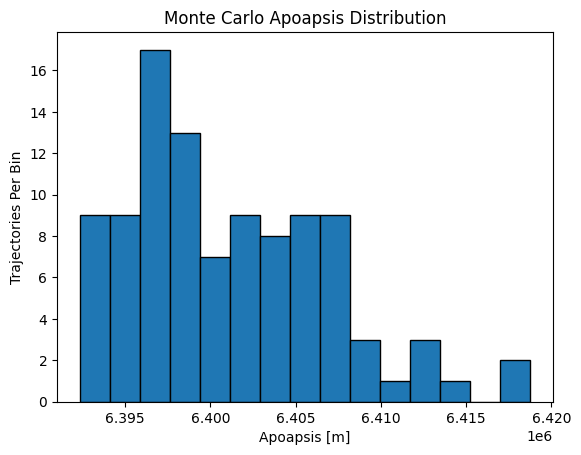

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator
from scipy.stats.qmc import LatinHypercube
 
# Definitions of physical constants:
G = 6.674*(10**-11)# -gravitational constant at sea level
p0 = 1.225 # -air density at sea level
H = 8500 # -a typical scale height 
M = 5.972*(10**24) # -mass of earth
R = 6.371*(10**6) # -radius of earth
Cd = 0.5 # -drag coefficient of rocket
mdry = 500 # -dry mass of rocket
mpayload = 50 # -mass of payload
mprop0 = 1200 # -inital propellant mass
ve = 3000 # -exhaust velocity 
theta = np.pi/3 # -launch angle
A = 0.5 # -surface area 
x0 = 0 # -initial x position
y0 = R # -initial y position 
vx0 = 0 # -initial x velocity
vy0 = 0 # -initial y velocity
t0 = 0 # -initial time 
tf = 800 # -final time
h = 0.005 # -RK4 step size
N = 100 # -number of Monte Carlo runs

# Define function that includes the entire computational operation for Monte Carlo looping
def simulation(G,p0,H,M,R,Cd,mdry,mpayload,mprop0,ve,theta,A,x0,y0,vx0,vy0,t0,tf,h):
    # Definition of two-dimensional position and velocity functions for magnitude
    def magr(x, y):
        return np.sqrt(x**2 + y**2)
    def magv(vx, vy):
        return np.sqrt(vx**2 + vy**2)

    # Definition of the atmospheric density based on position
    def p(x,y):
        return p0*np.e**(-(magr(x,y)-R)/H)

    # Definition of the drag at a given altitude with velocity in the direction of v/||v||
    def Dx(vx, vy, x, y):
        return -0.5*p(x,y)*Cd*A*magv(vx,vy)*vx
    def Dy(vx, vy, x, y):
        return -0.5*p(x,y)*Cd*A*magv(vx,vy)*vy

    # Definition of the thrust magnitude at any given time using an interpolation of real thrust curve data
    # Load CSV file of raw data
    data = np.loadtxt("stage1_boost_thrust.csv", delimiter=",", skiprows=1)

    # Separate columns into arrays
    time = data[:, 0]
    thrust = data[:, 1]*5

    # Interpolate data for continuous function
    interp = PchipInterpolator(time, thrust)
    def T(t):
        val = interp(t)
        if t > 8:
            val = 0
        return val

    # Define instantaneous mass flow rate based on T(t) and ve
    def dmprop(t,x,y,vx,vy,mprop):
        dmprop = -T(t)/ve
        return dmprop

    # Define dx/dt as x velocity
    def dx(t,x,y,vx,vy,mprop):
        return vx

    # Define dy/dt as y velocity
    def dy(t,x,y,vx,vy,mprop):
        return vy

    # Define acceleration for x and y using the given model
    def dvx(t,x,y,vx,vy,mprop):
        return (-G*M)/(magr(x, y)**3)*x + (T(t)/(mprop + mdry + mpayload))*np.cos(theta) + (Dx(vx, vy, x, y)/(mprop + mdry + mpayload))

    def dvy(t,x,y,vx,vy,mprop):
        return (-G*M)/(magr(x, y)**3)*y + (T(t)/(mprop + mdry + mpayload))*np.sin(theta) + (Dy(vx, vy, x, y)/(mprop + mdry + mpayload))

    # Implement RK4
    def RK4(dx,x0,dy,y0,dvx,vx0,dvy,vy0,dmprop,mprop0,t0,tf,h):
        times = np.arange(t0,tf+h,h)
        n = len(times)
        
        # Make empty arrays and then initialize them
        xs = np.zeros(n)
        ys = np.zeros(n)
        vxs = np.zeros(n)
        vys = np.zeros(n)
        mprops = np.zeros(n)

        xs[0] = x0
        ys[0] = y0
        vxs[0] = vx0
        vys[0] = vy0
        mprops[0] = mprop0

        for i in range(n-1):
            kdx1 = dx(t0,x0,y0,vx0,vy0,mprop0)
            kdy1 = dy(t0,x0,y0,vx0,vy0,mprop0)
            kdvx1 = dvx(t0,x0,y0,vx0,vy0,mprop0)
            kdvy1 = dvy(t0,x0,y0,vx0,vy0,mprop0)
            kdmprop1 = dmprop(t0,x0,y0,vx0,vy0,mprop0)

            kdx2 = dx(t0 + h/2, x0 + h*kdx1/2, y0 + h*kdy1/2, vx0 + h*kdvx1/2, vy0 + h*kdvy1/2, mprop0 + h*kdmprop1/2)
            kdy2 = dy(t0 + h/2, x0 + h*kdx1/2, y0 + h*kdy1/2, vx0 + h*kdvx1/2, vy0 + h*kdvy1/2, mprop0 + h*kdmprop1/2)
            kdvx2 = dvx(t0 + h/2, x0 + h*kdx1/2, y0 + h*kdy1/2, vx0 + h*kdvx1/2, vy0 + h*kdvy1/2, mprop0 + h*kdmprop1/2)
            kdvy2 = dvy(t0 + h/2, x0 + h*kdx1/2, y0 + h*kdy1/2, vx0 + h*kdvx1/2, vy0 + h*kdvy1/2, mprop0 + h*kdmprop1/2)
            kdmprop2 = dmprop(t0 + h/2, x0 + h*kdx1/2, y0 + h*kdy1/2, vx0 + h*kdvx1/2, vy0 + h*kdvy1/2, mprop0 + h*kdmprop1/2)

            kdx3 = dx(t0 + h/2, x0 + h*kdx2/2, y0 + h*kdy2/2, vx0 + h*kdvx2/2, vy0 + h*kdvy2/2, mprop0 + h*kdmprop2/2)
            kdy3 = dy(t0 + h/2, x0 + h*kdx2/2, y0 + h*kdy2/2, vx0 + h*kdvx2/2, vy0 + h*kdvy2/2, mprop0 + h*kdmprop2/2)
            kdvx3 = dvx(t0 + h/2, x0 + h*kdx2/2, y0 + h*kdy2/2, vx0 + h*kdvx2/2, vy0 + h*kdvy2/2, mprop0 + h*kdmprop2/2)
            kdvy3 = dvy(t0 + h/2, x0 + h*kdx2/2, y0 + h*kdy2/2, vx0 + h*kdvx2/2, vy0 + h*kdvy2/2, mprop0 + h*kdmprop2/2)
            kdmprop3 = dmprop(t0 + h/2, x0 + h*kdx2/2, y0 + h*kdy2/2, vx0 + h*kdvx2/2, vy0 + h*kdvy2/2, mprop0 + h*kdmprop2/2)

            kdx4 = dx(t0 + h, x0 + h*kdx3, y0 + h*kdy3, vx0 + h*kdvx3, vy0 + h*kdvy3, mprop0 + h*kdmprop3)
            kdy4 = dy(t0 + h, x0 + h*kdx3, y0 + h*kdy3, vx0 + h*kdvx3, vy0 + h*kdvy3, mprop0 + h*kdmprop3)
            kdvx4 = dvx(t0 + h, x0 + h*kdx3, y0 + h*kdy3, vx0 + h*kdvx3, vy0 + h*kdvy3, mprop0 + h*kdmprop3)
            kdvy4 = dvy(t0 + h, x0 + h*kdx3, y0 + h*kdy3, vx0 + h*kdvx3, vy0 + h*kdvy3, mprop0 + h*kdmprop3)
            kdmprop4 = dmprop(t0 + h, x0 + h*kdx3, y0 + h*kdy3, vx0 + h*kdvx3, vy0 + h*kdvy3, mprop0 + h*kdmprop3)

            x1 = x0 + (h/6)*(kdx1 + 2*kdx2 + 2*kdx3 + kdx4)
            y1 = y0 + (h/6)*(kdy1 + 2*kdy2 + 2*kdy3 + kdy4)
            vx1 = vx0 + (h/6)*(kdvx1 + 2*kdvx2 + 2*kdvx3 + kdvx4)
            vy1 = vy0 + (h/6)*(kdvy1 + 2*kdvy2 + 2*kdvy3 + kdvy4)
            mprop1 = mprop0 + (h/6)*(kdmprop1 + 2*kdmprop2 + 2*kdmprop3 + kdmprop4)
            t1 = t0 + h

            # Safeguard against the simulation proceeding through the body of the earth
            if np.sqrt(x1**2 + y1**2) <= R:
                print("Rocket hit ground at step", i)
                break
            
            # Safeguard against NaNs getting caught up in the arrays (was a problem earlier)
            if np.isnan(x1) or np.isnan(y1) or np.isnan(vx1) or np.isnan(vy1):
                print("NaN detected at step", i)
                break

            # Fix propellant mass and thrust at zero after all the propellant is burned
            if mprop1 <= 0:
                mprop1 = 0
            
            # Continue to fill the arrays with the next value
            times[i+1] = t1
            xs[i+1] = x1
            ys[i+1] = y1
            vxs[i+1] = vx1
            vys[i+1] = vy1
            mprops[i+1] = mprop1
            
            # Update
            x0 = x1
            y0 = y1
            vx0 = vx1
            vy0 = vy1
            mprop0 = mprop1
            t0 = t1
        return times[:(i+1)], xs[:(i+1)], ys[:(i+1)], vxs[:(i+1)], vys[:(i+1)], mprops[:(i+1)]

    times, xs, ys, vxs, vys, mprops = RK4(dx,x0,dy,y0,dvx,vx0,dvy,vy0,dmprop,mprop0,t0,tf,h)

    # Compute orbital energy using the given epsilon function
    def epsilon():
        values = []
        for a,b,c,d in zip(xs,ys,vxs,vys):
            values.append(0.5*(c**2 + d**2) - (G*M/(np.sqrt(a**2 + b**2))))
        return values

    # Use the energy at apogee for the apoapsis and periapsis calculations
    r = np.sqrt(xs**2 + ys**2)
    eps = epsilon()
    epsf = eps[np.argmax(r)]

    # Compute angular momentum using given L function
    def L():
        values = []
        for a,b,c,d in zip(xs,ys,vxs,vys):
            values.append(a*d - b*c)
        return values
    # Use L at apogee for subsequent calculations
    Ls = L()
    Lf = np.abs(Ls[np.argmax(r)])

    # Compute orbital checks along with apoapsis and periapsis
    a = -G*M/(2*epsf)
    e = np.sqrt(1 +(2*epsf*Lf**2)/(G*M)**2)
    rperi = a*(1 - e)
    rapo = a*(1 + e)

    # Graph thrust curve for accuracy checks and viewing convenience 
    t_fine = np.linspace(0, time[-1], 1000)  # 1000 points between 0 and last time
    thrust_smooth = interp(t_fine)

    return times, xs, ys, vxs, vys, mprops, rapo, rperi, time, thrust, t_fine, thrust_smooth, epsf, Lf
times, xs, ys, vxs, vys, mprops, rapo, rperi, time, thrust, t_fine, thrust_smooth, epsf, Lf = simulation(G,p0,H,M,R,Cd,mdry,mpayload,mprop0,ve,theta,A,x0,y0,vx0,vy0,t0,tf,h)

print("Results specific to the nominal trajectory:")
print('Specific orbital energy at apogee (epsf) =', epsf,'m²/s²')
print('Angular momentum at apogee (Lf) =', Lf,'m²/s')
if epsf >= 0:
        print('Escaped') 
if epsf < 0 and rperi > R:
        print('Bound')
if epsf < 0 and rperi <= R:
        print('Suborbital')
print("Distance from earth's center of mass:")
print('Apoapsis =', rapo,'m')
print('Periapsis =', rperi,'m')

# Plot interpolated thrust curve over original data for comparison
plt.plot(time, thrust, 'o', label='Original Data')
plt.plot(t_fine, thrust_smooth, '-', label='PCHIP Smooth')
plt.xlabel("Time [s]")
plt.ylabel("Thrust [N]")
plt.legend()
plt.show()

# Graphs of y(x), x(t), y(t), v(t), mprop(t)
plt.plot(xs, ys - R)
plt.axis('equal')
plt.xlabel('$X$ [m]')
plt.ylabel('$Y$ [m]')
plt.grid(True)
plt.show()

plt.plot(times, xs)
plt.xlabel('Time [s]')
plt.ylabel('$X$ [m]')
plt.grid(True)
plt.show()

plt.plot(times, ys - R)
plt.xlabel('Time [s]')
plt.ylabel('$Y$ [m]')
plt.grid(True)
plt.show()

v = np.sqrt(vxs**2 + vys**2)
plt.plot(times, v)
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.show()

plt.plot(times, mprops)
plt.xlabel('Time [s]')
plt.ylabel('Propellant Mass [kg]')
plt.grid(True)
plt.show()

# Use quasi-random number generator for Monte Carlo
sampler = LatinHypercube(d=3)
U = sampler.random(n=N)

# Create lists for each varied parameter (launch angle, drag coefficient, and dry mass)
thetas = (U[:,0]*(np.pi/18)) + ((np.pi/3)-(np.pi/36))
Cds = (U[:,1]*(0.2)) + 0.4
mdrys = (U[:,2]*(50)) + 475

# Create figure for the trajectories
plt.figure()
plt.grid(True)
plt.axis("equal")
plt.xlabel("X [m]")
plt.ylabel("Y [m]")
plt.title("Monte Carlo Trajectory Distribution")

# Loop through each Monte Carlo repetition of the simulation 
apoapses = [] # create empty list to later fill with apoapsis values for histogram
for k in range(N):
    times, mcxs, mcys, _, _, _, mcrapo, *_ = simulation(G,p0,H,M,R,Cds[k],mdrys[k],mpayload,mprop0,ve,thetas[k],A,x0,y0,vx0,vy0,t0,tf,h)
    plt.plot(mcxs, mcys - R, alpha=0.4)
    apoapses.append(mcrapo)
plt.plot(xs,ys - R, linewidth = 3, label = "Nominal Trajectory") # bold nominal trajectory for clarity
plt.legend()
plt.show()

# Create histogram of apoapsis values
plt.hist(apoapses, bins=15, edgecolor = "black")
plt.xlabel("Apoapsis [m]")
plt.ylabel("Trajectories Per Bin")
plt.title("Monte Carlo Apoapsis Distribution")
plt.show()